In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

import learning

from importlib import reload

In [2]:
from sklearn.datasets import make_circles

C:\Users\Danny\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


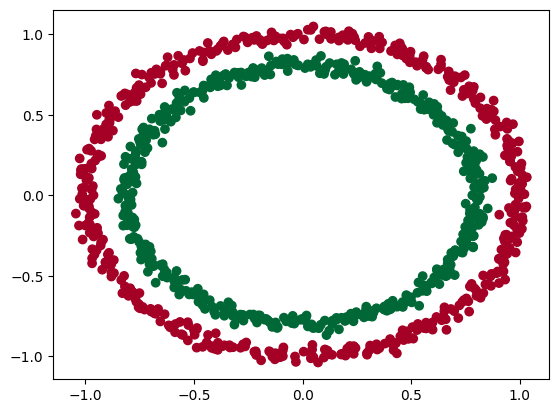

In [3]:
circles = make_circles(n_samples=1000, noise=0.026)
circles_X = circles[0]
circles_y = circles[1]

plt.scatter(
    x=circles_X[:, :1], y=circles_X[:, 1:], c=circles_y, cmap=plt.cm.RdYlGn
)

In [93]:
reload(learning)

<module 'learning' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\learning.py'>

## Birds Eye Pytorch

In its simplest form, a neural network is just a function which takes in values, uses a bunch of numerical weights which are updated using gradient descent to reduce loss, and produces a number from the inputs.

Here, we see a very simple neural network which takes in a linear array of x values and tries to approximate the y value of each based. In this case the labels are the actual Y values of a sine wave function, and the loss function is just MSE, showing how far each point is from the actual sine wave point.

As far as pytorch is concerned, a dataset is just any value which returns a tuple of (image, label) given an index. Note that the dataset is a tuple of 2d tensors. The first tensor is the list of inputs and the second array is the list of outputs. A DataLoader is just taking that dataset and splitting it into batches. Here, we ignore validation and training sets for simplicity.

In this case, we have only 1 input value and 1 output value, so we have to unsqueeze the tensor.

In words, what we're doing here is telling the computer:
* Here's a list of x values, try to predict the y values based on how close I indicate you are from the actual value we're looking for (the label)
* For each batch of data, based on the derivative of the loss function (the gradient), adjust the weights in the direction, and by the magnitude, indicated by the gradient. The learning rate also determines the magnitude of the adjustment. If learning rate is too high for the given model, **the loss can quickly become so high that it overflows the integer container**. If this happens, the divergence is usually unrecoverable (diverges further each time). In that case, we must reduce the learning rate.
* There are a ton of ways to improve the final loss here, including just setting epochs super high. Will need to figure out a way to figure the best options here eventually.
* After a number of **epochs** (full passes through the dataset), our model creates a set of weights which best approximate our target function.

Output()

Final loss: 0.21609100864152425

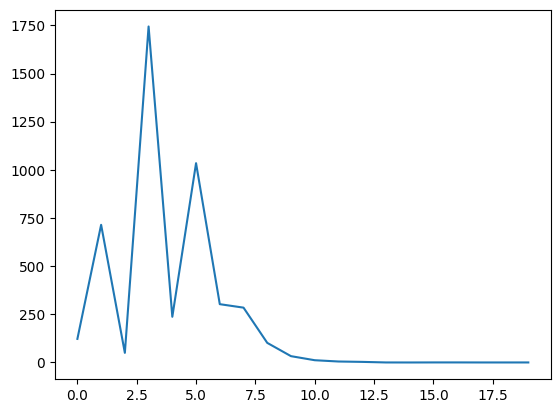

In [162]:
torch.manual_seed(42)

# Simple -5 to 5 range with 100 steps
X = torch.linspace(-5, 5, 100)
# Create a simple sine wave as our target for prediction
y = torch.sin(X)

# Datasets need to be in the form of 1 array per dataset. Since we only have 1 value per, just unsqueeze.
# Unsqueeze takes single values [1,2,3] and makes them have 1 row each [[1], [2]. [3]], which is what we need
dataset = list(zip(X.unsqueeze(1), y.unsqueeze(1)))

# A simple model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1)
).to("cuda")

# More complex, harder to tune learn rate, etc. Probably would end up better with more tweaks?
# model = torch.nn.Sequential(
#     torch.nn.Linear(1, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 1),
# ).to("cuda")

epochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# Higher learning rates better for more complex model
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.04, steps_per_epoch=len(dataset), epochs=epochs
# )
scheduler = None

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        torch.utils.data.DataLoader(dataset, batch_size=10), 
        torch.utils.data.DataLoader(dataset, batch_size=10),
        torch.utils.data.DataLoader(dataset, batch_size=10)
    ),
    model=model,
    loss_function=torch.nn.MSELoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device="cuda"
    # device="cpu"
)
learner.train_model(epochs)
learner.plot_epoch_data()

The final epoch's loss can be displayed visually by graphing the original sine wave alongside a single full forward pass of the x data to the model.

In essense, we're saying, hey model, based on the weights you've learned, go ahead and make 1 prediction for every input value. Then, we graph this.

The lower the final loss, the closer the graph ends up to the target.

We've basically emulated a "sine wave" mathematical function, without knowing that we were estimating a sine wave. The resulting function is a bunch of linear weights and biases with a nonlinear function in between.

mse: 0.21609102189540863


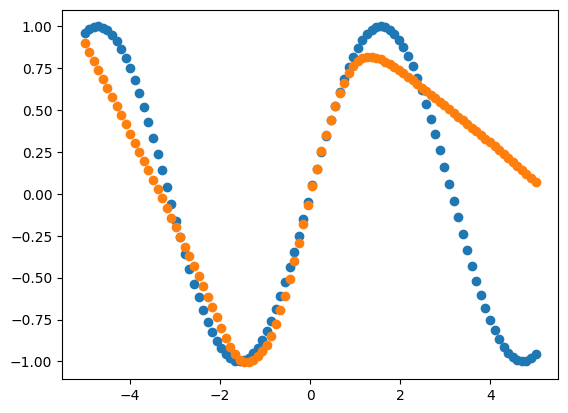

In [163]:
with torch.inference_mode():
    y_preds = model(X.unsqueeze(1).to("cuda"))
    
print(f"mse: {torch.nn.MSELoss()(y_preds, y.unsqueeze(1).to('cuda'))}")
plt.scatter(x=X, y=y)
plt.scatter(x=X, y=y_preds.cpu())